# Multi modal data processing -  End to end example using Amazon Bedrock Knowledge Bases for text & images

Multi-modal RAG can analyze and leverage insights from both textual and visual data, such as images, charts, diagrams, and tables.Bedrock Knowledge Bases offers end-to-end managed Retrieval-Augmented Generation (RAG) workflow that enables customers to create highly accurate, low-latency, secure, and custom generative AI applications by incorporating contextual information from their own data sources.

Bedrock Knowledge Bases extracts content from both text and visual data, generates semantic embeddings using the selected embedding model, and stores them in the chosen vector store. This enables users to retrieve and generate answers to questions derived not only from text but also from visual data. Additionally, retrieved results now include source attribution for visual data, enhancing transparency and building trust in the generated outputs.

You can choose between: Amazon Bedrock Data Automation, a managed service that automatically extracts content from multimodal data (currently in Preview), or FMs such as Claude 3.5 Sonnet or Claude 3 Haiku, with the flexibility to customize the default prompt.

This notebook provides sample code for building a Multimodal RAG using Amazon Bedrock Knowledge Bases.

#### Steps: 
- Create Knowledge Base execution role with necessary policies for accessing/writing data from/to S3 and required Foundation models .
- Create a knowledge base with rich content documents
- Create data source(s) within knowledge base
- Start ingestion jobs using KB APIs which which will read data from the data source, parse the documents (images, charts, tables etc.)using Bedrock Data Automation or Foundation model, chunk it, convert chunks into embeddings using Amazon Titan Embeddings model and then store these embeddings in AOSS. All of this without having to build, deploy and manage the data pipeline.

Once the data is available in the Bedrock Knowledge Base then a question answering application can be built using the Knowledge Base APIs provided by Amazon Bedrock.



#### Pre-requisites:

Please make sure to enable `Anthropic Claude 3 Sonnet` , `Amazon Nova Micro` and  `Titan Text Embeddings V2` model access in Amazon Bedrock Console

<div class="alert alert-block alert-info">
<b>Note:</b> Please run the notebook cell one at a time instead of using "Run All Cells" option.
</div>


### 0 - Setup
Before running the rest of this notebook, you'll need to run the cells below to (ensure necessary libraries are installed and) connect to Bedrock.

Please ignore any pip dependency error (if you see any while installing libraries)

In [1]:
# %pip install --force-reinstall -q -r ../../requirements.txt --quiet

# %pip install boto3 opensearch-py botocore awscli retrying ragas=0.1.9 ipywidgets  iprogressretrying langchain langchain_aws langchain_community --quiet 

In [2]:
# %pip install --upgrade boto3
import boto3
print(boto3.__version__)

1.35.81


In [3]:
# restart kernel
from IPython.core.display import HTML
HTML("<script>Jupyter.notebook.kernel.restart()</script>")

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
import os
import sys
import time
import boto3
import logging
import pprint
import json

SCRIPT_DIR = os.path.dirname(os.path.abspath("./"))
sys.path.append(os.path.dirname(SCRIPT_DIR))

from utils.knowledge_base import BedrockKnowledgeBase

In [6]:
#Clients
s3_client = boto3.client('s3')
sts_client = boto3.client('sts')
session = boto3.session.Session()
region =  session.region_name
account_id = sts_client.get_caller_identity()["Account"]
bedrock_agent_client = boto3.client('bedrock-agent')
bedrock_agent_runtime_client = boto3.client('bedrock-agent-runtime') 
logging.basicConfig(format='[%(asctime)s] p%(process)s {%(filename)s:%(lineno)d} %(levelname)s - %(message)s', level=logging.INFO)
logger = logging.getLogger(__name__)
region, account_id

('us-west-2', '017444429555')

In [7]:
import time

# Get the current timestamp
current_time = time.time()

# Format the timestamp as a string
timestamp_str = time.strftime("%Y%m%d%H%M%S", time.localtime(current_time))[-7:]
# Create the suffix using the timestamp
suffix = f"{timestamp_str}"

knowledge_base_name = f"bedrock-multi-modal-kb-{suffix}"
knowledge_base_description = "Multi-modal RAG knowledge base."

bucket_name = f'{knowledge_base_name}-{account_id}'
# intermediate_bucket_name = f'{knowledge_base_name}-mm-storage-{account_id}'
foundation_model = "anthropic.claude-3-sonnet-20240229-v1:0"

#### You can add multiple data sources (S3, Sharepoint) to a multimodal Knowledge Base. For this notebook, we'll test Knowledge Base creation with S3 Bucket.


Each data source may have different pre-requisites, please refer to the AWS documetation for more information.

In [8]:
## Please uncomment the data sources that you want to add and update the placeholder values accordingly.

data_sources=[
                {"type": "S3", "bucket_name": bucket_name}, 

                # {"type": "SHAREPOINT", "tenantId": "888d0b57-69f1-4fb8-957f-e1f0bedf64de", "domain": "yourdomain",
                #   "authType": "OAUTH2_CLIENT_CREDENTIALS",
                #  "credentialsSecretArn": f"arn:aws::secretsmanager:{region_name}:secret:<<your_secret_name>>",
                #  "siteUrls": ["https://yourdomain.sharepoint.com/sites/mysite"]
                # },
            ]
                
pp = pprint.PrettyPrinter(indent=2)

### 1 - Create Knowledge Base

In [9]:
knowledge_base = BedrockKnowledgeBase(
    kb_name=f'{knowledge_base_name}',
    kb_description=knowledge_base_description,
    data_sources=data_sources,
    multi_modal= True,
    parser='BEDROCK_DATA_AUTOMATION', #BEDROCK_FOUNDATION_MODEL 
    chunking_strategy = "FIXED_SIZE", 
    suffix = f'{suffix}-f'
)

[2024-12-13 21:30:19,983] p63247 {credentials.py:1278} INFO - Found credentials in shared credentials file: ~/.aws/credentials
[2024-12-13 21:30:20,905] p63247 {credentials.py:1278} INFO - Found credentials in shared credentials file: ~/.aws/credentials


Step 1 - Creating or retrieving S3 bucket(s) for Knowledge Base documents
['bedrock-multi-modal-kb-3213019-017444429555', 'bedrock-multi-modal-kb-3213019-intermediate-3213019-f']
buckets_to_check:  ['bedrock-multi-modal-kb-3213019-017444429555', 'bedrock-multi-modal-kb-3213019-intermediate-3213019-f']
Creating bucket bedrock-multi-modal-kb-3213019-017444429555
Creating bucket bedrock-multi-modal-kb-3213019-intermediate-3213019-f
Step 2 - Creating Knowledge Base Execution Role (AmazonBedrockExecutionRoleForKnowledgeBase_3213019-f) and Policies
Step 3 - Creating OSS encryption, network and data access policies
Step 4 - Creating OSS Collection (this step takes a couple of minutes to complete)
{ 'ResponseMetadata': { 'HTTPHeaders': { 'connection': 'keep-alive',
                                         'content-length': '320',
                                         'content-type': 'application/x-amz-json-1.0',
                                         'date': 'Sat, 14 Dec 2024 05:30:25 '
 

[2024-12-13 21:35:59,822] p63247 {base.py:258} INFO - PUT https://t09xhluqncp6618plobh.us-west-2.aoss.amazonaws.com:443/bedrock-sample-rag-index-3213019-f [status:200 request:1.408s]



Creating index:
{ 'acknowledged': True,
  'index': 'bedrock-sample-rag-index-3213019-f',
  'shards_acknowledged': True}
Step 6 - Will create Lambda Function if chunking strategy selected as CUSTOM
Not creating lambda function as chunking strategy is FIXED_SIZE
Step 7 - Creating Knowledge Base
{ 'createdAt': datetime.datetime(2024, 12, 14, 5, 37, 0, 340352, tzinfo=tzutc()),
  'description': 'Multi-modal RAG knowledge base.',
  'knowledgeBaseArn': 'arn:aws:bedrock:us-west-2:017444429555:knowledge-base/JKAE9F2NVJ',
  'knowledgeBaseConfiguration': { 'type': 'VECTOR',
                                  'vectorKnowledgeBaseConfiguration': { 'embeddingModelArn': 'arn:aws:bedrock:us-west-2::foundation-model/amazon.titan-embed-text-v2:0',
                                                                        'supplementalDataStorageConfiguration': { 'storageLocations': [ { 's3Location': { 'uri': 's3://bedrock-multi-modal-kb-3213019-intermediate-3213019-f'},
                                    

### 2 - Data Ingestion
We'll download publically available rich content PDF and upload it to an S3 bucket

In [10]:
import os

def create_directory(directory_name):    
    if not os.path.exists(directory_name):
        os.makedirs(directory_name)
        print(f"Directory '{directory_name}' created successfully.")
    else:
        print(f"Directory '{directory_name}' already exists.")

# Call the function to create the directory
create_directory("mm-data")

Directory 'mm-data' created successfully.


In [11]:
import requests

def download_file(url, filename):
    # Send a GET request to the URL
    response = requests.get(url)
    
    # Check if the request was successful
    if response.status_code == 200:
        # Open the file in write-binary mode
        with open(filename, 'wb') as file:
            # Write the content of the response to the file
            file.write(response.content)
        print(f"File downloaded successfully: {filename}")
    else:
        print(f"Failed to download file. Status code: {response.status_code}")

# URL of the file to download
url = "https://sgp.fas.org/crs/misc/IF12695.pdf"

# Name for the downloaded file
filename = "./mm-data/tornadoes_report.pdf"

# Call the function to download the file
download_file(url, filename)

File downloaded successfully: ./mm-data/tornadoes_report.pdf


##### Upload data to S3 Bucket data source

In [12]:
def upload_directory(path, bucket_name):
        for root,dirs,files in os.walk(path):
            for file in files:
                file_to_upload = os.path.join(root,file)
                print(f"uploading file {file_to_upload} to {bucket_name}")
                s3_client.upload_file(file_to_upload,bucket_name,file)

upload_directory("./mm-data", bucket_name)

uploading file ./mm-data/tornadoes_report.pdf to bedrock-multi-modal-kb-3213019-017444429555


### Start ingestion job
Once the KB and data source(s) created, we can start the ingestion job for each data source.
During the ingestion job, KB will fetch the documents from the data source, Parse the document to extract text, chunk it based on the chunking size provided, create embeddings of each chunk and then write it to the vector database, in this case OSS.

NOTE: Currently, you can only kick-off one ingestion job at one time.

In [13]:
# ensure that the kb is available
time.sleep(30)
# sync knowledge base
knowledge_base.start_ingestion_job()

job 1 started successfully

{ 'dataSourceId': 'S9UFAEAFC0',
  'ingestionJobId': 'CJUTWQFOAN',
  'knowledgeBaseId': 'JKAE9F2NVJ',
  'startedAt': datetime.datetime(2024, 12, 14, 5, 37, 37, 131493, tzinfo=tzutc()),
  'statistics': { 'numberOfDocumentsDeleted': 0,
                  'numberOfDocumentsFailed': 0,
                  'numberOfDocumentsScanned': 1,
                  'numberOfMetadataDocumentsModified': 0,
                  'numberOfMetadataDocumentsScanned': 0,
                  'numberOfModifiedDocumentsIndexed': 0,
                  'numberOfNewDocumentsIndexed': 1},
  'status': 'COMPLETE',
  'updatedAt': datetime.datetime(2024, 12, 14, 5, 38, 48, 322720, tzinfo=tzutc())}


In [14]:
# keep the kb_id for invocation later in the invoke request
kb_id = knowledge_base.get_knowledge_base_id()
%store kb_id

'JKAE9F2NVJ'
Stored 'kb_id' (str)


### 4 -  Test the Knowledge Base
Now the Knowlegde Base is available we can test it out using the [**retrieve**](https://boto3.amazonaws.com/v1/documentation/api/latest/reference/services/bedrock-agent-runtime/client/retrieve.html) and [**retrieve_and_generate**](https://boto3.amazonaws.com/v1/documentation/api/latest/reference/services/bedrock-agent-runtime/client/retrieve_and_generate.html) functions. 

#### Testing Knowledge Base with Retrieve and Generate API

Let's first test the knowledge base using the retrieve and generate API. With this API, Bedrock takes care of retrieving the necessary references from the knowledge base and generating the final answer using a foundation model from Bedrock.

query = `Summarize annual trends of tornado reports and how it varies year over year.`

The right response for this query is expected to fetch from a chart/graph from the PDF document.

In [15]:
query = "Summarize annual trends of tornado reports and how it varies year over year."

In [16]:
foundation_model = "anthropic.claude-3-sonnet-20240229-v1:0"
# foundation_model = "amazon.nova-micro-v1:0"

response = bedrock_agent_runtime_client.retrieve_and_generate(
    input={
        "text": query
    },
    retrieveAndGenerateConfiguration={
        "type": "KNOWLEDGE_BASE",
        "knowledgeBaseConfiguration": {
            'knowledgeBaseId': kb_id,
            "modelArn": "arn:aws:bedrock:{}::foundation-model/{}".format(region, foundation_model),
            "retrievalConfiguration": {
                "vectorSearchConfiguration": {
                    "numberOfResults":5
                } 
            }
        }
    }
)

print(response['output']['text'],end='\n'*2)

According to the search results, the annual number of reported tornadoes in the United States has significant year-to-year variability. The chart in search result 3 shows the daily tornado count and running annual trend for 2024 as of November 25th. It indicates that 2024 had an extremely high number of reported tornadoes in November, far exceeding the average daily trend from 2005-2015. However, the search results note that it is difficult to discern if the average number of tornadoes per year has changed over time or if more tornadoes are simply being reported due to factors like better detection methods, increased population, and the rise of technologies like cell phone cameras. The results state that experts have difficulty determining whether climate change has impacted tornado frequency or intensity overall.



In [17]:
from PIL import Image
import s3fs

fs = s3fs.S3FileSystem()

## Function to print retrieved response

def print_response(response):
#structure 'retrievalResults': list of contents. Each list has ['ResponseMetadata', 'citations', 'output', 'sessionId']
    print( f'OUTPUT: {response["output"]["text"]} \n')
    
    print(f'CITATION DETAILS: \n')
    
    for num, chunk in enumerate(response['citations']):
        print(f'CHUNK {num}',end='\n'*1)
        print("========")
        print(f'\t Generated  Response Text: ')
        print(f'\t ------------------------- ')
        print(f'\t Generated  Response Text: ',chunk['generatedResponsePart']['textResponsePart']['text'],end='\n'*2)
        for i, ref in enumerate (chunk['retrievedReferences']):
            print(f'\t Retrieved References: ')
            print(f'\t ---------------------', )
            print(f'\n\t\t --> Location:', ref['location'])
            print(f'\t\n\t\t --> Metadata: \n\t\t\t ---> Source', ref['metadata']['x-amz-bedrock-kb-source-uri'])
            # print(f'\t\n\t\t\n\t\t\t ---> x-amz-bedrock-kb-description', ref['metadata']['x-amz-bedrock-kb-description'])
            print(f'\t\n\t\t\n\t\t\t ---> x-amz-bedrock-kb-byte-content-source', ref['metadata']['x-amz-bedrock-kb-byte-content-source'])
            print("")
            with fs.open(ref['metadata']['x-amz-bedrock-kb-byte-content-source']) as f:
                display(Image.open(f).resize((400, 400)))

[2024-12-13 21:39:35,386] p63247 {credentials.py:1278} INFO - Found credentials in shared credentials file: ~/.aws/credentials


OUTPUT: According to the search results, the annual number of reported tornadoes in the United States has significant year-to-year variability. The chart in search result 3 shows the daily tornado count and running annual trend for 2024 as of November 25th. It indicates that 2024 had an extremely high number of reported tornadoes in November, far exceeding the average daily trend from 2005-2015. However, the search results note that it is difficult to discern if the average number of tornadoes per year has changed over time or if more tornadoes are simply being reported due to factors like better detection methods, increased population, and the rise of technologies like cell phone cameras. The results state that experts have difficulty determining whether climate change has impacted tornado frequency or intensity overall. 

CITATION DETAILS: 

CHUNK 0
	 Generated  Response Text: 
	 ------------------------- 
	 Generated  Response Text:  According to the search results, the annual numbe

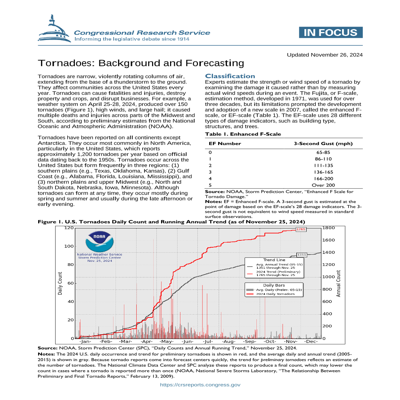

CHUNK 1
	 Generated  Response Text: 
	 ------------------------- 
	 Generated  Response Text:  However, the search results note that it is difficult to discern if the average number of tornadoes per year has changed over time or if more tornadoes are simply being reported due to factors like better detection methods, increased population, and the rise of technologies like cell phone cameras. The results state that experts have difficulty determining whether climate change has impacted tornado frequency or intensity overall.

	 Retrieved References: 
	 ---------------------

		 --> Location: {'s3Location': {'uri': 's3://bedrock-multi-modal-kb-3213019-017444429555/tornadoes_report.pdf'}, 'type': 'S3'}
	
		 --> Metadata: 
			 ---> Source s3://bedrock-multi-modal-kb-3213019-017444429555/tornadoes_report.pdf
	
		
			 ---> x-amz-bedrock-kb-byte-content-source s3://bedrock-multi-modal-kb-3213019-intermediate-3213019-f/aws/bedrock/knowledge_bases/JKAE9F2NVJ/S9UFAEAFC0/43adf07b-6a7d-4b39-9679-8

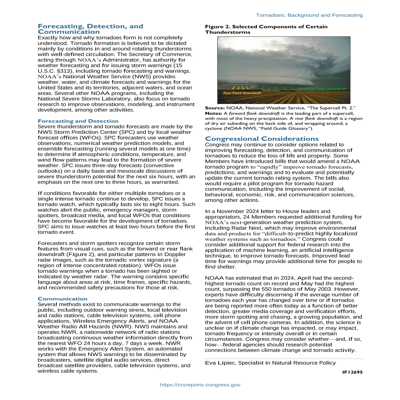

In [18]:
print_response(response)

#### Testing Knowledge Base with Retrieve API
If you need an extra layer of control, you can retrieve the chuncks that best match your query using the retrieve API. In this setup, we can configure the desired number of results and control the final answer with your own application logic. The API then provides you with the matching content, its S3 location, the similarity score and the chunk metadata.

Chunk 1:  

Chunk 1 Location:  {'s3Location': {'uri': 's3://bedrock-multi-modal-kb-3213019-017444429555/tornadoes_report.pdf'}, 'type': 'S3'}

Chunk 1 Score:  0.3432486

Chunk 1 Metadata:  {'x-amz-bedrock-kb-source-uri': 's3://bedrock-multi-modal-kb-3213019-017444429555/tornadoes_report.pdf', 'x-amz-bedrock-kb-description': '# Tornadoes: Background and Forecasting\n## Forecasting, Detection, and Communication\nExactly how and why tornadoes form is not completely understood. Tornado formation is believed to be dictated mainly by conditions in and around rotating thunderstorms with well-defined circulation. The Secretary of Commerce, acting through NOAA\'s Administrator, has authority for weather forecasting and for issuing storm warnings (15 U.S.C. $313), including tornado forecasting and warnings. NOAA\'s National Weather Service (NWS) provides weather, water, and climate forecasts and warnings for the United States and its territories, adjacent waters, and ocean areas. Several other N
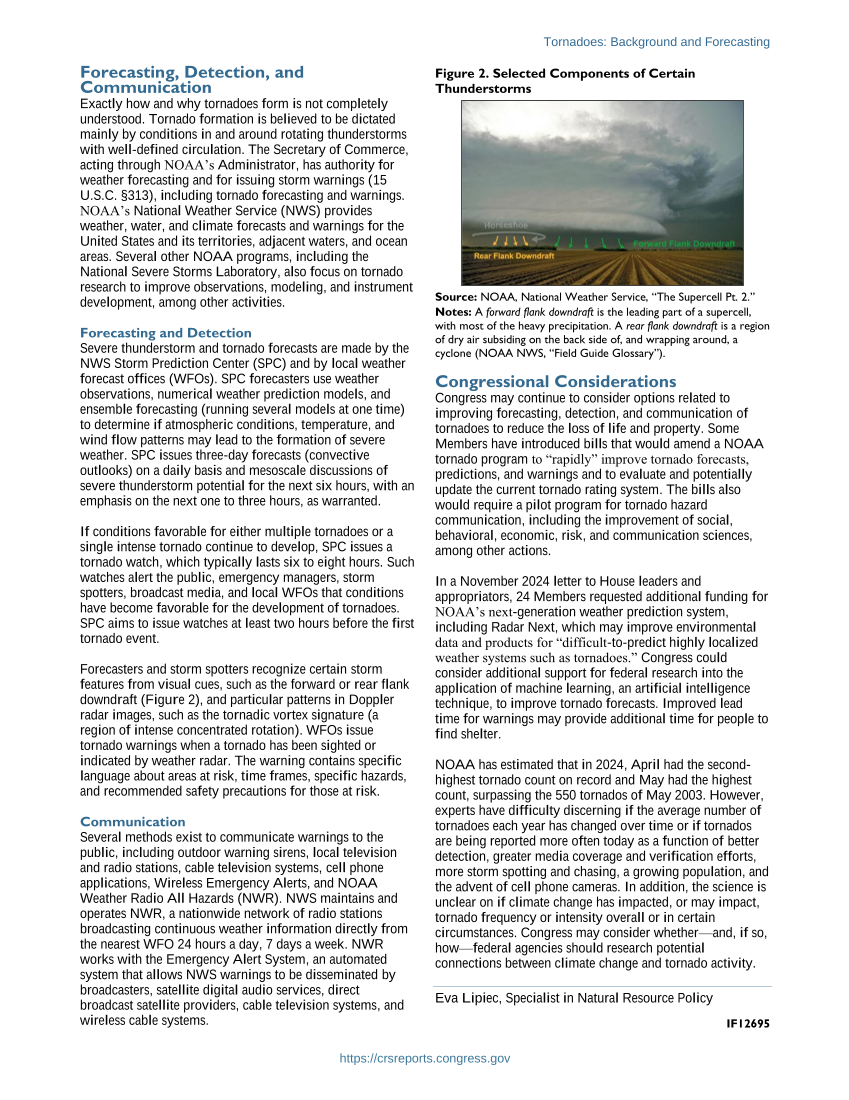
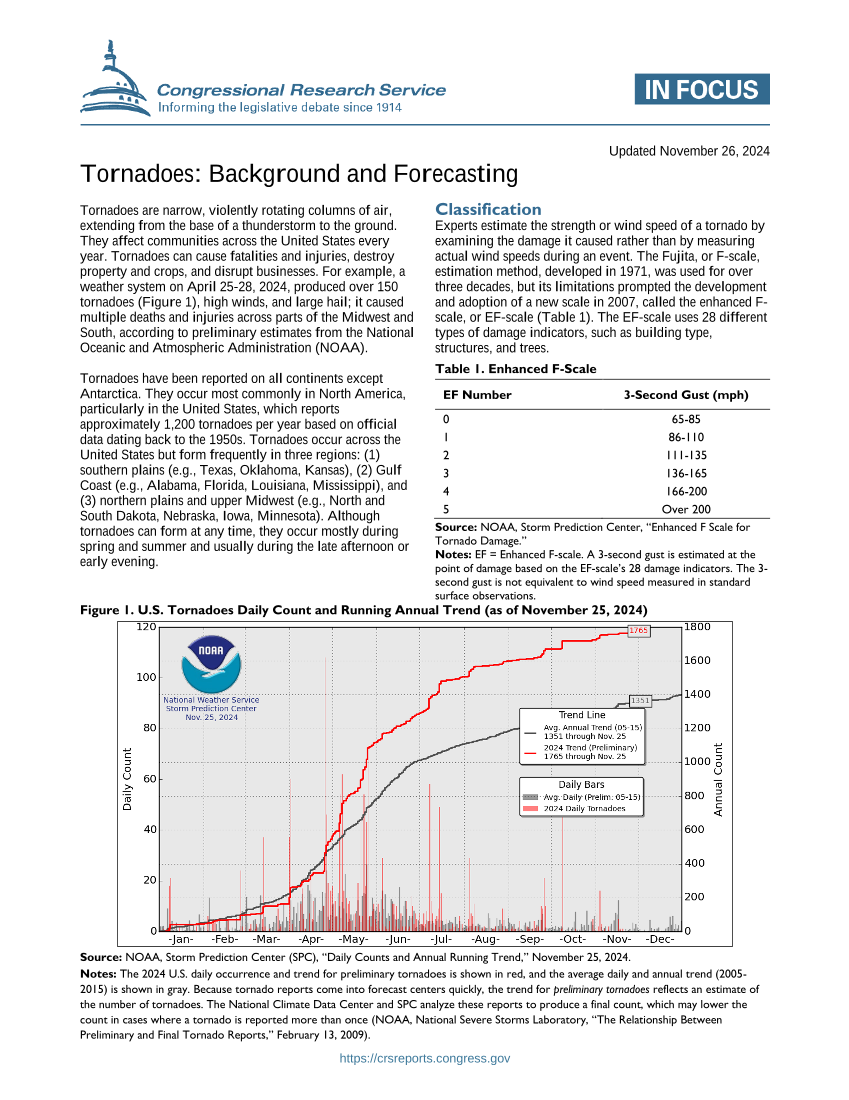

In [19]:
response_ret = bedrock_agent_runtime_client.retrieve(
    knowledgeBaseId=kb_id, 
    nextToken='string',
    retrievalConfiguration={
        "vectorSearchConfiguration": {
            "numberOfResults":5,
        } 
    },
    retrievalQuery={
        "text": "How many new positions were opened across Amazon's fulfillment and delivery network?"
    }
)

def response_print(retrieve_resp):
#structure 'retrievalResults': list of contents. Each list has content, location, score, metadata
    for num,chunk in enumerate(response_ret['retrievalResults'],1):
        if 'text' in chunk['content']:
            print(f'Chunk {num}: ',chunk['content']['text'],end='\n'*2)
        if 'byteContent' in chunk['content']:
            print(f'Chunk {num}: ',chunk['content']['byteContent'],end='\n'*2)
        print(f'Chunk {num} Location: ',chunk['location'],end='\n'*2)
        print(f'Chunk {num} Score: ',chunk['score'],end='\n'*2)
        print(f'Chunk {num} Metadata: ',chunk['metadata'],end='\n'*2)
        print("--------------------------------")

response_print(response_ret)

### Clean up
Please make sure to uncomment and run the below section to delete all the resources.

In [20]:
# delete local directory
import shutil

dir_path = "mm-data" # Replace with the actual path

try:
    shutil.rmtree(dir_path)
    print(f"Directory '{dir_path}' and its contents have been deleted successfully.")
except FileNotFoundError:
    print(f"Directory '{dir_path}' not found.")
except Exception as e:
        print(f"An error occurred: {e}")

Directory 'mm-data' and its contents have been deleted successfully.


In [21]:
# delete role and policies
print("===============================Knowledge base with fixed chunking==============================\n")
knowledge_base.delete_kb(delete_s3_bucket=True, delete_iam_roles_and_policies=True)

===============================Knowledge base with fixed chunking==============================

0
======== Knowledge base and data source deleted =========
======== Vector Index, collection and associated policies deleted =========
======== All IAM roles and policies deleted =========
======== S3 bucket bedrock-multi-modal-kb-3213019-017444429555 deleted =========
======== S3 bucket bedrock-multi-modal-kb-3213019-intermediate-3213019-f deleted =========
======== All S3 buckets deleted =========


In [22]:
# # delete data sources
# ds_id_list = bedrock_agent_client.list_data_sources(
#     knowledgeBaseId='XF3SGAQGWM',
#     maxResults=100
# )['dataSourceSummaries']

# ds_id_list

# for idx, ds in enumerate(ds_id_list):
#     print(ds_id_list[idx]["dataSourceId"])
#     try:
#         bedrock_agent_client.delete_data_source(
#             dataSourceId=ds[idx]["dataSourceId"],
#             knowledgeBaseId='XF3SGAQGWM'
#         )
#     except Exception as e:
#         print(e)

# # delete KB
# try:
#     bedrock_agent_client.delete_knowledge_base(
#         knowledgeBaseId='ZA3YL4QAUM'
#     )
#     print("======== Knowledge base and data source deleted =========")
# except bedrock_agent_client.exceptions.ResourceNotFoundException as e:
#     print("Resource not found", e)
# except Exception as e:
#     print(e)
        